In [2]:
from lib.data import *
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps
import economic_complexity as ecplx
#from informe import SimuladorEstatico, SimuladorDinamico, SimuladorComplejo, PaisNaive
from informe import *
from lib.utils import correr_simulacion_mostrando, cantidad_descubrimientos_iteracion
import numpy as np

data, raw = get_default_oec_rca_raw_data()

ModuleNotFoundError: No module named 'requests'

In [2]:
rca = ecplx.rca(data)
M = build_M_from(rca)

In [3]:
cigarras = SimuladorComplejo(lambda step: step > 25, PaisCigarra, M.copy(deep=True), 0.1)
hormigas = SimuladorComplejo(lambda step: step > 25, PaisHormiga, M.copy(deep=True), 0.1)

grafo_inicial = cigarras.grafo( )
PCI_inicial = cigarras.PCI.copy( deep=True )

historia_cigarras = correr_simulacion_mostrando(cigarras, False)
historia_hormigas = correr_simulacion_mostrando(hormigas, False)

proximidad calculada en: 0.10527348518371582
paises creados en: 0.0
proximidad calculada en: 0.10734915733337402
paises creados en: 0.006434917449951172
empezando simulación: 2024-06-30 15:50:03
empezando simulación: 2024-06-30 15:50:48


In [37]:
def plot_grafo_estatico( res_iteracion, G, PCI, country_name, cmap='Reds' ):
    cm = colormaps[ cmap ]
    PCI -= np.min( PCI )
    PCI /= np.max(PCI)
    PCI = (20 * PCI) ** 2

    pos = nx.spring_layout(G, dim=2, k=1.3)
    nx.draw(G, pos, with_labels=False, node_color='white',  edgecolors='gray', node_size=PCI.values, width=0.01, edgelist=[] )

    productos_iniciales = M.loc[country_name]
    productos_iniciales = productos_iniciales[productos_iniciales == 1].index.to_list()

    nx.draw_networkx_nodes(G, pos, 
        nodelist=productos_iniciales, 
        node_color='#cccccc', 
        node_size=PCI.loc[productos_iniciales].values, edgecolors='gray')

    for iteracion in range( 0,len(res_iteracion)):
        nodos_exportados = res_iteracion[iteracion][country_name]

        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodos_exportados, 
                               node_color=np.array(list(cm(iteracion / len(res_iteracion))))[:3].reshape(1,-1), 
                               node_size=PCI.loc[nodos_exportados].values, edgecolors='gray')
        
    if np.array_equal(res_iteracion, historia_cigarras):
        plt.title(country_name, loc='left', fontsize=16, y=1.02)  
        plt.suptitle('Cigarra', fontsize=14, x=0, y=1.03, ha='left', va='top') 
    elif np.array_equal(res_iteracion, historia_hormigas):
        plt.title(country_name, loc='left', fontsize=16, y=1.02)  
        plt.suptitle('Hormiga', fontsize=14, x=0, y=1.03, ha='left', va='top')
    plt.show()

In [3]:
plot_grafo_estatico( historia_cigarras, grafo_inicial.copy(), PCI_inicial.copy(), 'Germany', 'Reds' )

NameError: name 'plot_grafo_estatico' is not defined

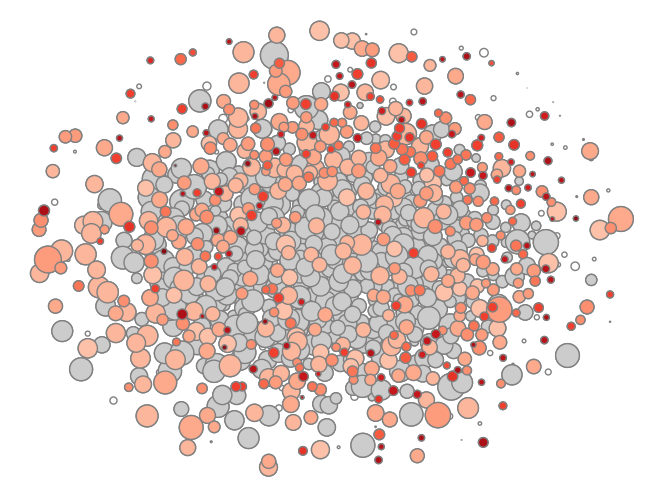

In [39]:
plot_grafo_estatico( historia_hormigas, grafo_inicial.copy(), PCI_inicial.copy(), 'Germany', 'Reds' )

In [ ]:
plot_grafo_estatico( historia_hormigas, grafo_inicial.copy(), PCI_inicial.copy(), 'Argentina', 'Reds' )

In [ ]:
plot_grafo_estatico( historia_cigarras, grafo_inicial.copy(), PCI_inicial.copy(), 'Argentina', 'Reds' )